In [1]:
JupLab = False
prop = 'Head CoM'

# Annotated skeleton of a moving sperm cell
*For now I have only worked with the test data *data_9-2.tif**

First, I tried using a plugin of ImageJ (Qualitative Annotations) but it didn't have many features so I looked for a different software. Then, I found Make Sense (https://www.makesense.ai/) which helped greatly in annotating points. It also allows for annotations in the shape of rectangles, lines and polygons, although the output files types are not something I have worked with before. What I accomplished with Make Sense is described next.

In the sperm cell I tried annotating four parts:
- **Head tip**. The head tip was not easy to track as most of the time I could not see the full head. Therefore the head CoM is a more trustworthy measure.
- **Head CoM**. The CoM was evaluated by eye, trying to aim for the center of what was visible of the head.
- **Midpiece**. These points mark the change between the head and the tail.
- **Tail end**. It was pointless to try and find the tail ends because, even when the tail is visible, there is no telling whether I am able to see the actual end or not. This should be improved to annotate the tail itself, however long it is in each timeframe, and in that way also keep track of its movement.

I annotated the two vesicles to measure the speed of the fluid itself.

Other than the sperm cells, there are some vesicles present in the fluid. These vesicles are shaped similarly to spheres and serve as transportion devices. What is being transported is kept in the middle, surrounded by a layer of fat that repels the liquid and therefore causes the sphere-like shape.

*The fluid that keeps the spermatozoa moves through the tube when performing the LSFM on it on the first dataset, although it shouldn't. There shouldn't be a flow but because maybe the tube was tilted or there was a leak, movement in the 'x' direction is seen in the first dataset.*

In [2]:
import numpy as np
import pandas as pd
from skimage import io
from matplotlib import colors
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from sklearn.cluster import SpectralClustering
from mpl_toolkits.axes_grid1 import make_axes_locatable
#notebook or widget
%matplotlib notebook

from matplotlib.pyplot import rcParams as rc
rc['figure.figsize'] = [5.0,4.0]

In [3]:
#The voxel size of the first dataset is 0.29x0.29x3 um
#The voxel size of the second dataset is 0.4x0.4x3 um
vox_x = 0.29 #um
vox_y = 0.29 #um
vox_z = 3.   #um

In [4]:
#The annotations are saved as a csv file
#The dataframe is tweaked slightly to show only the parameters we are intereseted in

df = pd.read_csv('png/labels_data_9-2_png.csv')
df = df.drop(['349', '175'], axis=1)
df['Frame'] = df.file_name.replace('data_9-2_|.png', '', regex=True).astype('int64')

df['x_pix'] = df['x'] - 7 #The png image had a 7 pixel border
df['y_pix'] = df['y'] - 7
df['z_pix'] = df['Frame']%30
df.loc[(df.z_pix == 0), 'z_pix'] = 30
df['t'] = (df['Frame']/31).astype('int64') + 1

df = df.reindex(columns=['file_name', 'label', 'Frame', 'x_pix', 'y_pix', 'z_pix', 't'])

#Sort the df by increasing value of z to better find the mirrored clusters (and for each z, increasing in t)
df = df.sort_values(by=['z_pix', 't'])

In [5]:
#Print the shape of one image to know the size of all and fix the axis limits easily
#As well as write the x, y and z coordinates in real units instead of pixel
im = io.imread('png/data_9-2_1.png')

ymax_pix = im.shape[0] - 7.   #maximum is 313 in tif
scaley = 313/ymax_pix * vox_y #um
xmax_pix = im.shape[1] - 7.   #maximum is 650 in tif
scalex = 650/xmax_pix * vox_x #um

#Convert pixel resolution into real measures
df['x'] = df['x_pix']*scalex
df['y'] = df['y_pix']*scaley
df['z'] = df['z_pix']*vox_z

tmax = np.max(df['t'])       #maximum is 106
zmax = np.max(df['z'])       #um
ymax = np.max(df['y'])       #um
xmax = np.max(df['x'])       #um

print('Max t:', tmax)
print('Max z:', zmax)
print('Max y:', ymax)
print('Max x:', xmax)
#print('scale x and y:', scaley, scalex)

Max t: 103
Max z: 90.0
Max y: 82.12523809523809
Max x: 181.8859649122807


In [6]:
df

,file_name,label,Frame,x_pix,y_pix,z_pix,t,x,y,z
68,data_9-2_241.png,Head CoM,241,216,99,1,8,119.052632,53.489464,3.0
77,data_9-2_271.png,Head CoM,271,212,98,1,9,116.847953,52.949167,3.0
91,data_9-2_301.png,Head CoM,301,209,96,1,10,115.194444,51.868571,3.0
107,data_9-2_331.png,Head CoM,331,207,99,1,11,114.092105,53.489464,3.0
123,data_9-2_361.png,Head CoM,361,204,99,1,12,112.438596,53.489464,3.0
...,...,...,...,...,...,...,...,...,...,...
774,data_9-2_3030.png,Vesicle 1,3030,293,88,30,98,161.492690,47.546190,90.0
786,data_9-2_3060.png,Vesicle 1,3060,292,88,30,99,160.941520,47.546190,90.0
797,data_9-2_3090.png,Vesicle 1,3090,291,89,30,100,160.390351,48.086488,90.0
807,data_9-2_3120.png,Vesicle 1,3120,289,88,30,101,159.288012,47.546190,90.0


---
# Spectral Clustering
Now I plot all the points with the same label and find the clusters that make the cell and its mirrored images apart. The clustering is done through scikit learn with the implementation of spectral clustering. The only parameters that I chose were the number of clusters and _assign_labels_ always set to _'discretize'_.

First I tried to do 4D clustering (t,x,y,z):
- 4D clustering with 3 clusters --> the results aren't good, even for the 3 distinct clusters seen in vesicle 1. No clustering whatsoever for the head
- 4D clustering with 2 clusters --> it looks okay for vesicles but not for the head (only one cluster)

The variable _y_ does not seem to have any meaningful information so I try 3D clustering (t,x,z):
- 3D clustering with 3 clusters --> works perfectly for vesicle 1, finds clusters in head but not the good ones
- 3D clustering with 2 clusters --> not good

Trying with only 2D (t,z):
- 2D clustering with 3 clusters --> seems to give the same results as with the x dimension
- 2D clustering with 2 clusters --> not good

Seen that the _x_ dimension doesn't contribute I try with _y_ in 3D (t,y,z):
- 3D clustering with 3 clusters --> works perfectly for vesicle 1, finds clusters in head very close the good ones
- 3D clustering with 2 clusters --> better than with 3 clusters in the sense that it differentiates in two categories: cell and mirrors (**BEST RESULT!**)

In [7]:
mask = (df['label']==prop)

#Try to find the clusters with scikit learn
X = []
length = len(df.x[mask])
for i in range(length):
    X = np.append(X, (df.t[mask].iloc[i], df.y[mask].iloc[i], df.z[mask].iloc[i]))
X = X.reshape((length, 3))

clustering = SpectralClustering(n_clusters=3,
                                assign_labels='discretize',
                                random_state=0).fit(X)

<IPython.core.display.Javascript object>


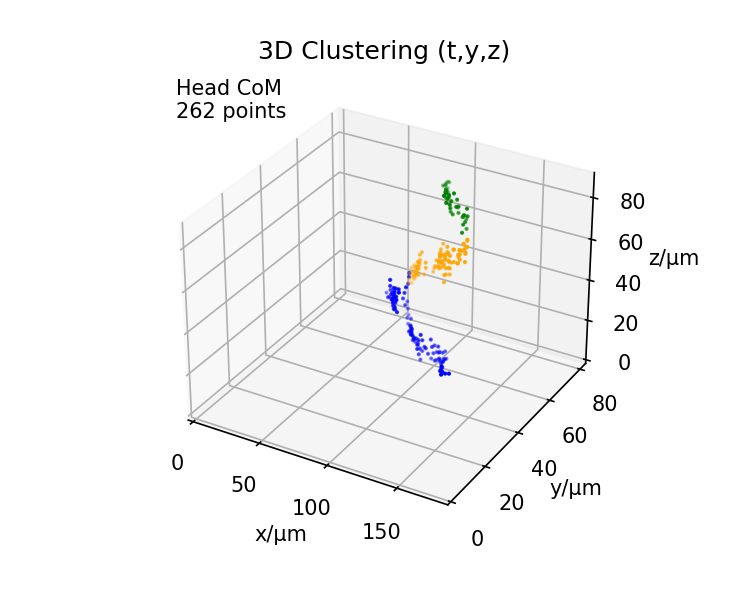

<IPython.core.display.Javascript object>


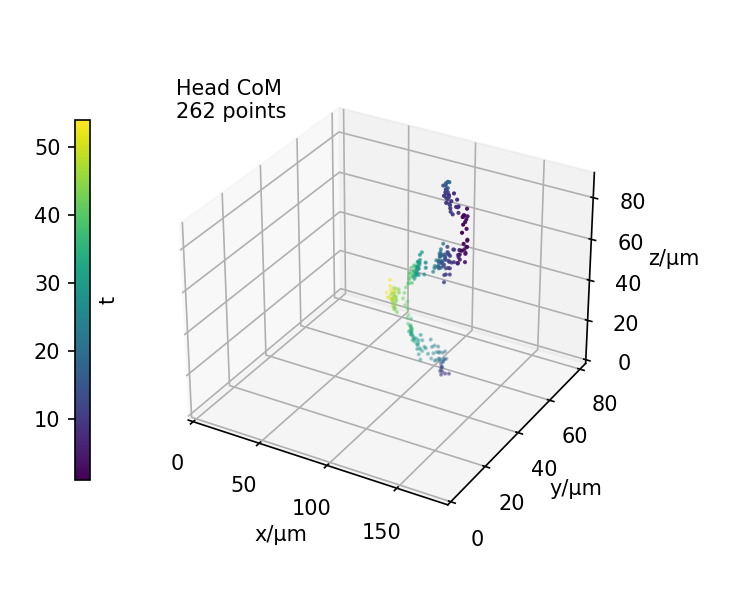

In [8]:
if JupLab:
    %matplotlib inline
    
clust0 = (clustering.labels_==0)
clust1 = (clustering.labels_==1)
clust2 = (clustering.labels_==2)

fig1 = plt.figure()
ax1 = fig1.add_subplot(projection="3d")
ax1.set_title('3D Clustering (t,y,z)')
ax1.set_xlabel('x/μm'); ax1.set_ylabel('y/μm'); ax1.set_zlabel('z/μm')
ax1.set_xlim(0,xmax);   ax1.set_ylim(0,ymax);   ax1.set_zlim(0,zmax)
ax1.text2D(0.05, 0.90, '%s \n%i points' % (prop, len(df.x[mask])), transform=ax1.transAxes)

ax1.scatter(df.x[mask][clust0], df.y[mask][clust0], df.z[mask][clust0], s=1, color='b')
ax1.scatter(df.x[mask][clust1], df.y[mask][clust1], df.z[mask][clust1], s=1, color='orange')
ax1.scatter(df.x[mask][clust2], df.y[mask][clust2], df.z[mask][clust2], s=1, c='g')


fig2 = plt.figure()
ax2 = fig2.add_subplot(projection="3d")
#ax2.set_title('')
ax2.set_xlabel('x/μm'); ax2.set_ylabel('y/μm'); ax2.set_zlabel('z/μm')
ax2.set_xlim(0,xmax);   ax2.set_ylim(0,ymax);   ax2.set_zlim(0,zmax)
ax2.text2D(0.05, 0.90, '%s \n%i points' % (prop, len(df.x[mask])), transform=ax2.transAxes)

p = ax2.scatter(df.x[mask], df.y[mask], df.z[mask], c=df.t[mask], s=1, cmap='viridis')

cbax = fig2.add_axes([0.1, 0.2, 0.02, 0.6]) #Adding the colorbar to the left (x start, y start, width, length)
cbar = fig2.colorbar(p, cax=cbax, label='t')
cbar.ax.yaxis.set_ticks_position('left')
cbar.ax.yaxis.set_label_position('right')
#Adding a colorbar to the bottom
#cbar = fig2.colorbar(p, ax=[ax2], location='bottom', shrink=0.65, label='t')
#cbar.ax.invert_xaxis()

plt.show()

The best result is achieved with 3D clustering (t,y,z) but it still does not work properly for x<80 (where the cell and its mirror merge). Therefore I will stop the path of spectral custering, since it is not straightforward and not worth it to spend more time on it.

Questions:
- How to check whether a clustering is good or bad?

---
## Manual clustering
I try finding the clusters manually in each timeframe

In [ ]:
def findClusters(z, dist):
    """
    The function identifies different clusters in a specific timeframe, by measuring distances between points in
    the z direction. 
    Parameters:    z: array of the points' z coordinates.
                   dist: maximum distance between points in the z direction to be considered in the same cluster.
    Returns:       clust: boolean matrix organizing the points in clusters. Dimensions are (number of clusters, len(z))
    """
    clust = np.full((2,len(z)), False)
    clust_empty = np.full(len(z), False)
    
    z_prev = z[0]
    clust[0,0] = True
    
    row = 0
    for i in range(1, len(z)):
        if np.abs(z[i] - z_prev) <= dist:
            clust[row,i] = True
        else:
            clust = np.vstack([clust,clust_empty])
            row += 1
            clust[row,i] = True  
        z_prev = z[i]
        
    clust = np.delete(clust, -1, axis=0)
    return clust

In [ ]:
def chooseMainCluster(clust):
    """
    The function aims at finding the main cluster and tracking it through the time series.
    Parameters:    clust: boolean matrix organizing the points in clusters. Dimensions are (number of clusters, len(z))
    Returns:       main_clust: index of the main_clust in each timeframe.
    """
    main_clust = 0
    len_clust = len(np.ones(len(clust[0]))[clust[0]])
    for i in range(clust.shape[0]):
        clusti = clust[i]
        len_clusti = len(np.ones(len(clusti))[clusti])
        if len_clusti > len_clust:
            main_clust = i
            len_clust = len_clusti
    return main_clust

To choose the main cluster I tried:
- choosing the one in the middle - when there are only two, sometimes we're interested in the top and sometimes in the bottom one
- picking the longest one - apparently the main one is not always the longest one
- figure out how to always have 3 clusters but, in some frames, with 0 points in a cluster. Could be a problem if findClusters function found more than 3 clusters.

The results weren't conclusive and I tried to perfom spectral clustering automatically.

---
## Movie plot

In [21]:
def plot3D(prop, t):
    """
    The function plots in 3D all the points with the label *prop* at the time *t*, as well as their mean in each *t*.
    Parameters:    prop: refers to the label looking at - Head tip, Head CoM, Midpiece, Vesicle 1 or Vesicle 2.
                   t: is the timeframe chosen for the plot.
    Returns:       ax: plot axis, used in the animation.
                   avgx/y: mean value of all the points in the x/y direction.
                   avgz: mean value of the points in the main cluster in the z direction.
    """   
    mask = (df['label']==prop) & (df['t']==t)
    x = df.x[mask].to_numpy()
    y = df.y[mask].to_numpy()
    z = df.z[mask].to_numpy()
    
    ax.clear()
    ax.set_xlabel('x/μm'); ax.set_ylabel('y/μm'); ax.set_zlabel('z/μm')
    ax.set_xlim(0,xmax); ax.set_ylim(0,ymax); ax.set_zlim(0,zmax)
    ax.text2D(0.05, 0.95, 't = %i' % t, transform=ax.transAxes) #placement (0,0) would be the bottom left, (0,1) would be the top left
    
    #Find clusters of the mirrored cells and calculate the mean on z only in the main cluster
    #Manual clustering
    """
    clust = findClusters(z, 3.)
    main_clust = 0#chooseMainCluster(clust) #FIX THIS
    z_main = z[clust[main_clust,:]]
    """
    
    #Spectral clustering
    main_clust = (clustering.labels_==1)
    z_main = df.z[df['label']==prop][main_clust][df['t']==t]
    #We need to use df.z instead of z because the length of the clustering.labels_ is only after the prop mask
    #was performed and not the time one
    
    if len(z_main) > 0:
        avgx = np.mean(x); avgy = np.mean(y); avgz = np.mean(z_main)
        ax.scatter(x, y, z, 'b') #plot all points in the timeframe
        ax.scatter(avgx, avgy, avgz, color='orange')
    else:
        avgx = 0; avgy = 0; avgz = 0
    
    return ax, avgx, avgy, avgz

<IPython.core.display.Javascript object>


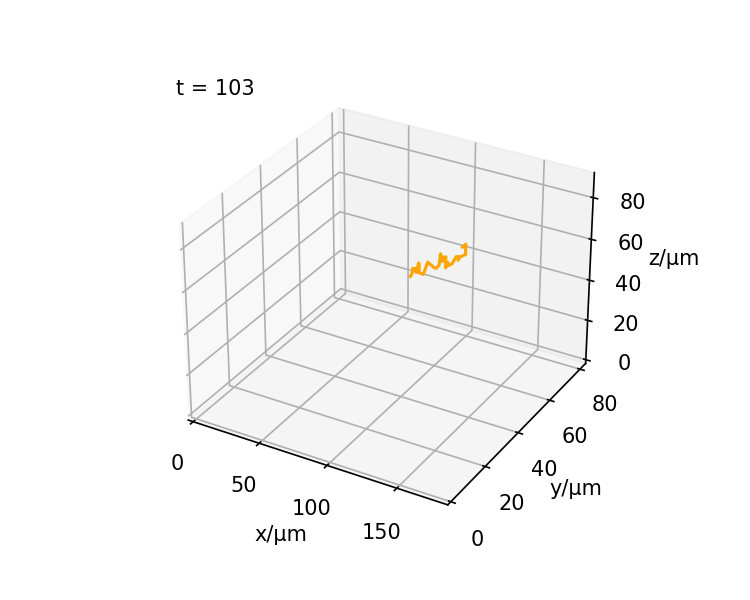

In [22]:
if JupLab:
    %matplotlib notebook

#Create an animation for all the timeframes. Annotated points in blue and their mean in orange.
fig = plt.figure()
ax = fig.add_subplot(projection="3d")
history_x = []; history_y = []; history_z = []

#file = open('avg_pos_headcom_clus2.txt','w')

def anim3D(t):
    ax, avgx, avgy, avgz = plot3D(prop, t)
    
    if avgy>0:
        if prop=='Head CoM':
            if avgx>80:
                history_x.append(avgx); history_y.append(avgy); history_z.append(avgz)
        else:
            history_x.append(avgx); history_y.append(avgy); history_z.append(avgz)
        #if t>0:
            #file.write(str([t, avgx, avgy, avgz])+'\n')
    ax.plot(history_x, history_y, history_z, color='orange') 
    
    return 0

ani = animation.FuncAnimation(fig, anim3D, tmax+1, interval=100, repeat=False, blit=True) #FIX THIS to have repeat=True

In [18]:
#file.close()

#For some reason there is a problem with saving the movie
import matplotlib as mpl
mpl.rcParams['animation.ffmpeg_path'] = r'C:\Users\34646\Escritorio\ffmpeg\bin\ffmpeg.exe'

writervideo = animation.FFMpegWriter(fps=60)
ani.save('movie.mp4', writer=writervideo)

---
# Motion descriptors
Now I try to find the motion descriptors based on the mean movement. Firstly, the speed of the cell and the vesicles is obtained.

In [32]:
filename = 'Motion descriptors/avg_pos_headcom_clus2.txt'
df_avg = pd.read_csv(filename, sep=",", header=None, names=['t', 'x', 'y', 'z'])
df_avg['t'] = df_avg.t.replace('\[|', '', regex=True).astype('int')
df_avg['z'] = df_avg.z.replace('|\]', '', regex=True).astype('float')

#d is the distance travelled between consecutive time steps
df_avg['t_diff'] = np.sqrt(df_avg['t'].diff()**2)
df_avg['vx'] = np.sqrt(df_avg['x'].diff()**2)/df_avg['t_diff']
df_avg['vy'] = np.sqrt(df_avg['y'].diff()**2)/df_avg['t_diff']
df_avg['vz'] = np.sqrt(df_avg['z'].diff()**2)/df_avg['t_diff']
df_avg['d'] = np.sqrt((df_avg['x'].diff())**2 + (df_avg['y'].diff())**2 + (df_avg['z'].diff())**2)

In [33]:
pd.set_option('display.max_rows', 6)
df_avg

,t,x,y,z,t_diff,vx,vy,vz,d
0,1,128.422515,52.733048,78.0,NaN,NaN,NaN,NaN,NaN
1,2,128.422515,54.786179,78.0,1.0,0.000000,2.053131,0.0,2.053131
2,3,127.650877,55.326476,79.5,1.0,0.771637,0.540298,1.5,1.771255
...,...,...,...,...,...,...,...,...,...
14,17,108.672271,58.081994,88.5,1.0,0.459308,0.486268,0.0,0.668895
15,18,107.753655,57.811845,90.0,1.0,0.918616,0.270149,1.5,1.779561
16,19,106.848162,59.046811,90.0,1.0,0.905493,1.234966,0.0,1.531358


In [34]:
x_diff_t = df_avg.x.iloc[-1] - df_avg.x.iloc[0]
y_diff_t = df_avg.y.iloc[-1] - df_avg.y.iloc[0]
z_diff_t = df_avg.z.iloc[-1] - df_avg.z.iloc[0]
t_diff_t = df_avg.t.iloc[-1] - df_avg.t.iloc[0]

tot_speed = np.sqrt(x_diff_t**2 + y_diff_t**2 + z_diff_t**2)/t_diff_t
print('Total speed: ', tot_speed, 'μm/time')

avg_speed = np.sum(df_avg.d)/t_diff_t
std_avg_speed = np.std(df_avg.d, ddof=1)/t_diff_t
print('Mean speed per time step: (', avg_speed, '+-', std_avg_speed, ') μm/time')

avg_speedx = np.sum(df_avg.vx)/t_diff_t
std_avg_speedx = np.std(df_avg.vx, ddof=1)/t_diff_t
print('Mean speed per time step in x: (', avg_speedx, '+-', std_avg_speedx, ') μm/time')

avg_speedy = np.sum(df_avg.vy)/t_diff_t
std_avg_speedy = np.std(df_avg.vy, ddof=1)/t_diff_t
print('Mean speed per time step in y: (', avg_speedy, '+-', std_avg_speedy, ') μm/time')

avg_speedz = np.sum(df_avg.vz)/t_diff_t
std_avg_speedz = np.std(df_avg.vz, ddof=1)/t_diff_t
print('Mean speed per time step in z: (', avg_speedz, '+-', std_avg_speedz, ') μm/time')

Total speed:  1.4156491975092569 μm/time
Mean speed per time step: ( 2.0414573635305873 +- 0.07982896481312066 ) μm/time
Mean speed per time step in x: ( 1.1005894365543507 +- 0.035677227767814804 ) μm/time
Mean speed per time step in y: ( 0.6756102502729482 +- 0.02824359419468418 ) μm/time
Mean speed per time step in z: ( 0.7777777777777778 +- 0.05957669608202005 ) μm/time


<IPython.core.display.Javascript object>


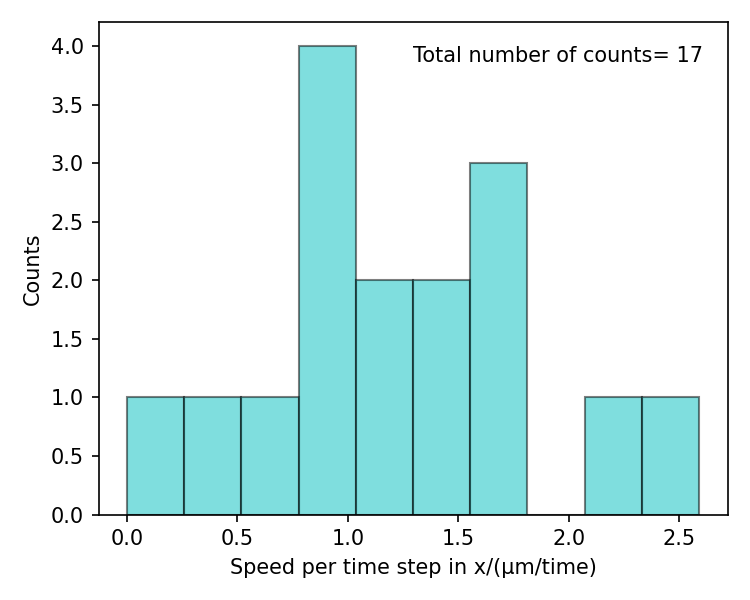

In [35]:
if JupLab:
    %matplotlib inline

fig, ax = plt.subplots(tight_layout=True)
ax.hist(df_avg.vx, facecolor='c', alpha=0.5, edgecolor = 'black', linewidth=1)#, align='left')
ax.set_xlabel('Speed per time step in x/(μm/time)')
ax.set_ylabel('Counts')
ax.text(0.5, 0.92, 'Total number of counts= %i' % len(df_avg.d), transform=ax.transAxes)

plt.show()

---
# Vesicles's sizes

In [ ]:
def measure(ves):
    mask_l = (df['label']=='Vesicle'+str(ves)+'_l')
    mask_r = (df['label']=='Vesicle'+str(ves)+'_r')
    return size

In [ ]:
#Vesicle 1
mask_l = (df['label']=='Vesicle 1_l')
mask_r = (df['label']=='Vesicle 1_r')
ves1 = np.sqrt((df[mask_l].x - df[mask_r].x)**2)

#Vesicle 2
mask_l = (df['label']=='Vesicle 2_l')
mask_r = (df['label']=='Vesicle 2_r')
#ves2 = np.abs(df['Vesicle 2_l'] - df['Vesicle 2_r'])

In [ ]:
print(ves1)